# 1. Sentiment analysis of online reviews

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import math
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import csv
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from scipy.linalg import svd


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zweedaothaiduy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zweedaothaiduy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zweedaothaiduy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.a Parse data files

In [2]:
yelp_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/sentiment-labelled-sentences/yelp_labelled.txt")
imdb_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/sentiment-labelled-sentences/imdb_labelled.txt")
amazon_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/sentiment-labelled-sentences/amazon_cells_labelled.txt")

yelp_data = list(csv.reader(yelp_file, delimiter='\t'))
imdb_data = list(csv.reader(imdb_file, delimiter='\t'))
amazon_data = list(csv.reader(amazon_file, delimiter='\t'))
yelp_df = pd.DataFrame(yelp_data, columns = ['text_t','is_positive'])
yelp_df['site_s']='yelp'
imdb_df = pd.DataFrame(imdb_data, columns = ['text_t','is_positive'])
imdb_df['site_s']='imdb'
amazon_df = pd.DataFrame(amazon_data, columns = ['text_t','is_positive'])
amazon_df['site_s']='amazon'

reviews_df = pd.concat([yelp_df, imdb_df, amazon_df], ignore_index=True)

num_positive = reviews_df.loc[reviews_df['is_positive'] == '1'].shape[0]
num_negative = reviews_df.loc[reviews_df['is_positive'] == '0'].shape[0]

ratio_positive_negative = num_positive / num_negative
print("Ratio of Positive vs Negative reviews:",ratio_positive_negative) # 1.01, it's balanced

Ratio of Positive vs Negative reviews: 1.0176211453744493


## 1.b Pre-processing 

In [6]:
#lowercase
reviews_df['text_t'] = [sentence.lower() for sentence in reviews_df['text_t']]

#strip punctuation
reviews_df['text_t'] = [re.sub(r'[^a-zA-Z ]', "", sentence) for sentence in reviews_df['text_t']]

#lemmatize
def lematize_sentence(sentence):
    wnl = nltk.WordNetLemmatizer()
    sentence_words = sentence.split()
    lematized_words = [wnl.lemmatize(word) for word in sentence_words if word != '']
    sentence = ' '.join(lematized_words)
    return sentence

reviews_df['text_t'] = [lematize_sentence(sentence) for sentence in reviews_df['text_t']]

#strip stop words
def strip_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_words = [word for word in word_tokens if word not in stop_words]
    sentence = ' '.join(filtered_words)
    return sentence

reviews_df['text_t'] = [strip_stopwords(sentence) for sentence in reviews_df['text_t']]


## 1.c Split training & test set

In [7]:
yelp_positive_df = reviews_df.loc[(reviews_df['site_s']=='yelp') & (reviews_df['is_positive']=='1')].head(400)
yelp_negative_df = reviews_df.loc[(reviews_df['site_s']=='yelp') & (reviews_df['is_positive']=='0')].head(400)
imdb_positive_df = reviews_df.loc[(reviews_df['site_s']=='imdb') & (reviews_df['is_positive']=='1')].head(300)
imdb_negative_df = reviews_df.loc[(reviews_df['site_s']=='imdb') & (reviews_df['is_positive']=='0')].head(300)
amazon_positive_df = reviews_df.loc[(reviews_df['site_s']=='amazon') & (reviews_df['is_positive']=='1')].head(400)
amazon_negative_df = reviews_df.loc[(reviews_df['site_s']=='amazon') & (reviews_df['is_positive']=='0')].head(400)

train_df = pd.concat([yelp_positive_df, yelp_negative_df, imdb_positive_df, imdb_negative_df, amazon_positive_df, amazon_negative_df])
test_df = reviews_df.loc[~reviews_df.index.isin(train_df.index)]

## 1.d Bag of Words model

In [8]:
#make unique words dictionary
unique_words = []
for sentence in train_df['text_t']:
    word_tokens = word_tokenize(sentence)
    unique_words.extend(word_tokens)
    unique_words = sorted(list(set(unique_words)))

#bag of words   
train_bow = pd.concat([train_df, pd.DataFrame(columns = unique_words)], axis=1, sort=False)
train_bow.reset_index(inplace = True, drop = True)
train_bow = train_bow.fillna(float(0))
test_bow = pd.concat([test_df, pd.DataFrame(columns = unique_words)], axis=1, sort=False)
test_bow.reset_index(inplace = True, drop = True)
test_bow = test_bow.fillna(float(0))

def bag_of_words(df):
    for i in df.index:
        sentence = df.loc[i,'text_t']        
        sentence_words = sentence.split()       
        bag_vector = np.zeros(len(unique_words))        
        for w in sentence_words:            
            for j,word in enumerate(unique_words):                
                if w == word:                  
                    df.loc[i,word] += 1
    return df                                   

train_bow = bag_of_words(train_bow)
test_bow = bag_of_words(test_bow)

## 1.e Post processing

In [9]:
#subtract mean & divide by variance
def standardize(df):
    standardized_df=(df-df.mean())/df.var()
    standardized_df = standardized_df.fillna(float(0))
    return standardized_df


train_bow.iloc[:,3:] = standardize(train_bow.iloc[:,3:])
test_bow.iloc[:,3:] = standardize(test_bow.iloc[:,3:])

## 1.f Sentiment Prediction

In [12]:
logReg = LogisticRegression()
logReg.fit(x_train, y_train)
lg_coefs = logReg.coef_[0]
lg_coefs = pd.DataFrame({'word':unique_words, 'coef':lg_coefs})
lg_coefs = lg_coefs.sort_values(by='coef', ascending=False)
print('Logistic Regression top positive predictors:')
print(lg_coefs.iloc[:10,:])
print('')
lg_coefs = lg_coefs.sort_values(by='coef')
print('Logistic Regression top negative predictors:')
print(lg_coefs.iloc[:10,:])
print('')
y_predict_lg = pd.DataFrame(logReg.predict(x_test))
print('Logistic Regression accuracy score:', accuracy_score(y_test,y_predict_lg))  #0.6861313868613139
print('Logistic Regression confusion matrix:')
print(confusion_matrix(y_test,y_predict_lg))
print('')

#Naive Bayes
BerNB = BernoulliNB()
BerNB.fit(x_train, y_train)

negative_predictors = BerNB.feature_log_prob_[0,:].argsort()[::-1]
positive_predictors = BerNB.feature_log_prob_[1,:].argsort()[::-1]

print('Naive Bayes top positive predictors:', [unique_words[i] for i in positive_predictors[:10]])
print('Naive Bayes top negative predictors:', [unique_words[i] for i in negative_predictors[:10]])

y_predict_NB = pd.DataFrame(BerNB.predict(x_test))
print('Naive Bayes accuracy score:', accuracy_score(y_test,y_predict_NB))  #0.7791970802919708
print('Naive Bayes confusion matrix:')
print(confusion_matrix(y_test,y_predict_NB))

/Users/zweedaothaiduy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression top positive predictors:
           word      coef
1570      great  0.633233
2097       look  0.352010
1226  excellent  0.303482
2627      phone  0.225580
2748      price  0.220559
2114       love  0.207506
4022       well  0.195918
3678       time  0.191579
103        also  0.184736
3149        see  0.173893

Logistic Regression top negative predictors:
        word      coef
2463     one -0.910137
3963      wa -0.883586
255      bad -0.683042
1206    even -0.384920
1029  doesnt -0.339037
1516     get -0.325623
2058    like -0.227682
2680    plot -0.188843
1526    give -0.173154
2289   money -0.163488

Logistic Regression accuracy score: 0.6861313868613139
Logistic Regression confusion matrix:
[[184  78]
 [ 94 192]]

Naive Bayes top positive predictors: ['wa', 'great', 'good', 'phone', 'movie', 'film', 'food', 'work', 'well', 'one']
Naive Bayes top negative predictors: ['wa', 'phone', 'bad', 'time', 'movie', 'food', 'would', 'dont', 'service', 'like']
Naive Bayes a

## 1.g N-gram model

In [14]:
from nltk.util import ngrams

def listToStr(string_list):
    final_str = ''
    for string in string_list:
        final_str += string + '_'
    final_str = final_str[:-1]
    return final_str

unique_ngrams = []
for sentence in train_df['text_t']:
    ngrams_tokens = ngrams(sentence.split(),2)
    unique_ngrams.extend(ngrams_tokens)
    unique_ngrams = sorted(list(set(unique_ngrams)))

#bag of words   
ngrams_df = pd.DataFrame(columns = pd.Series(unique_ngrams).map(listToStr))
train_ngrams = pd.concat([train_df, ngrams_df], axis=1, sort=False)
train_ngrams.reset_index(inplace = True, drop = True)
train_ngrams = train_ngrams.fillna(float(0))
test_ngrams = pd.concat([test_df, ngrams_df], axis=1, sort=False)
test_ngrams.reset_index(inplace = True, drop = True)
test_ngrams = test_ngrams.fillna(float(0))

def bag_of_ngrams(df):
    for i in df.index:
        sentence = df.loc[i,'text_t']        
        sentence_ngrams = ngrams(sentence.split(),2)     
        bag_vector = np.zeros(len(unique_ngrams))        
        for g in sentence_ngrams:            
            for j,unique_g in enumerate(unique_ngrams):                
                if g == unique_g:                  
                    df.loc[i,listToStr(unique_g)] += 1
    return df                                   

train_ngrams = bag_of_ngrams(train_ngrams)
test_ngrams = bag_of_ngrams(test_ngrams)

#Post processing: subtract mean & divide by variance
def standardize(df):
    standardized_df=(df-df.mean())/df.var()
    standardized_df = standardized_df.fillna(float(0))
    return standardized_df


train_ngrams.iloc[:,3:] = standardize(train_ngrams.iloc[:,3:])
test_ngrams.iloc[:,3:] = standardize(test_ngrams.iloc[:,3:])

#Sentiment Prediction
x_train = train_ngrams.iloc[:,3:]
y_train = train_ngrams.iloc[:,1]
x_test = test_ngrams.iloc[:,3:]
y_test = test_ngrams.iloc[:,1]

#Logistic Regression
logReg = LogisticRegression()
logReg.fit(x_train, y_train)
lg_coefs = logReg.coef_[0]
lg_coefs = pd.DataFrame({'ngram':unique_ngrams, 'coef':lg_coefs})
lg_coefs = lg_coefs.sort_values(by='coef', ascending=False)
print('Logistic Regression top positive predictors (2-grams):')
print(lg_coefs.iloc[:10,:])
print('')
lg_coefs = lg_coefs.sort_values(by='coef')
print('Logistic Regression top negative predictors (2-grams):')
print(lg_coefs.iloc[:10,:])
print('')

y_predict_lg = pd.DataFrame(logReg.predict(x_test))
print('Logistic Regression accuracy score (2-grams):', accuracy_score(y_test,y_predict_lg))  #0.6186131386861314
print('Logistic Regression confusion matrix (2-grams):')
print(confusion_matrix(y_test,y_predict_lg))
print('')

#Naive Bayes
BerNB = BernoulliNB()
BerNB.fit(x_train, y_train)

negative_predictors = BerNB.feature_log_prob_[0,:].argsort()[::-1]
positive_predictors = BerNB.feature_log_prob_[1,:].argsort()[::-1]

print('Naive Bayes top positive predictors (2-grams):', [unique_ngrams[i] for i in positive_predictors[:10]])
print('')
print('Naive Bayes top negative predictors (2-grams):', [unique_ngrams[i] for i in negative_predictors[:10]])
print('')

y_predict_NB = pd.DataFrame(BerNB.predict(x_test))
print('Naive Bayes accuracy score (2-grams):', accuracy_score(y_test,y_predict_NB))  #0.6076642335766423
print('Naive Bayes confusion matrix (2-grams):')
print(confusion_matrix(y_test,y_predict_NB))



/Users/zweedaothaiduy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression top positive predictors (2-grams):
                    ngram      coef
3614           (food, wa)  0.126875
11292       (work, great)  0.069949
11438  (would, recommend)  0.042304
4257       (great, phone)  0.033905
4231        (great, food)  0.028712
11314        (work, well)  0.028220
4265     (great, product)  0.027298
2649          (easy, use)  0.023526
10585     (wa, delicious)  0.021891
4106        (good, price)  0.019601

Logistic Regression top negative predictors (2-grams):
                    ngram      coef
10781      (wa, terrible) -0.056757
10918       (waste, time) -0.045782
10634          (wa, good) -0.042365
10915      (waste, money) -0.031452
8154   (recommend, place) -0.030929
10542           (wa, bad) -0.022349
10831    (waited, waited) -0.020063
2483          (dont, buy) -0.019978
7366    (place, deserves) -0.018400
11248        (wont, back) -0.018061

Logistic Regression accuracy score (2-grams): 0.6186131386861314
Logistic Regression confusion m

## 1.h PCA for bag of words

In [16]:
## 1.h PCA for bag of words
train_data = train_bow.iloc[:,3:]
U_train, s_train, VT_train = svd(train_data)
Sigma_train = np.zeros((train_data.shape[0], train_data.shape[1]))
Sigma_train[:train_data.shape[0], :train_data.shape[0]] = np.diag(s_train)

test_data = test_bow.iloc[:,3:]
U_test, s_test, VT_test = svd(test_data)
Sigma_test = np.zeros((test_data.shape[0], test_data.shape[1]))
Sigma_test[:test_data.shape[0], :test_data.shape[0]] = np.diag(s_test)


#Reduce dimension to r = {10; 50; 100}
print('PCA reduces dimentions')
r = 100
train_r = U_train[:,:r].dot(Sigma_train[:r,:r]).dot(VT_train[:r,:])
test_r = U_test[:,:r].dot(Sigma_test[:r,:r]).dot(VT_test[:r,:])

x_train = train_r
y_train = train_bow.iloc[:,1]
x_test = test_r
y_test = test_bow.iloc[:,1]

logReg = LogisticRegression()
logReg.fit(x_train, y_train)
y_predict_lg = pd.DataFrame(logReg.predict(x_test))
print('Logistic Regression accuracy score:', accuracy_score(y_test,y_predict_lg))  
#10 dimensions: 0.4781021897810219
#50 dimentions: 0.5127737226277372
#100 dimentions: 0.5145985401459854

BerNB = BernoulliNB()
BerNB.fit(x_train, y_train)
y_predict_NB = pd.DataFrame(BerNB.predict(x_test))
print('Naive Bayes accuracy score:', accuracy_score(y_test,y_predict_NB))  
#10 dimentions: 0.5218978102189781
#50 dimentions: 0.5218978102189781
#100 dimentions: 0.5218978102189781

PCA reduces dimensions
Logistic Regression accuracy score: 0.5109489051094891
Naive Bayes accuracy score: 0.5218978102189781


/Users/zweedaothaiduy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# 2. Clustering for text analysis

In [17]:
from sklearn import cluster

#Parse data file
science_doc_data= np.load("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/clustering-text/science2k-doc-word.npy")
science_word_data= np.load("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/clustering-text/science2k-word-doc.npy")
science_titles_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/clustering-text/science2k-titles.txt")
science_vocab_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/clustering-text/science2k-vocab.txt")

science_titles = pd.DataFrame(science_titles_file, columns=['title'])
science_vocab = pd.DataFrame(science_vocab_file, columns=['word'])
science_vocab = science_vocab.applymap(str.strip)

## 2.a Doc-word clustering

In [18]:

#computed per-document smoothed word frequencies
#just plus 3 to all values so they all become positive
science_doc_df = science_doc_data + 3
science_doc_df = pd.DataFrame(science_doc_df)

#took the log of those frequencies
science_doc_df = science_doc_df.applymap(math.log2)

#centered the per-document log frequencies to have zero mean
science_doc_df = science_doc_df - science_doc_df.mean()
science_doc_df.mean()

#Cluster the documents using k-means and various values of k (go up to at least k = 20).
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(science_doc_df)

science_doc_cluster = pd.concat([pd.DataFrame(k_means.labels_,columns=['cluster']),science_doc_df], axis=1, sort=False)

#report the top 10 words of each cluster in order of the largest positive distance from the average value across all data
def print_cluster(df,cluster_df,cluster_num):
    science_doc_distances = df[cluster_df['cluster']==cluster_num] - k_means.cluster_centers_[cluster_num]
    max_distances = pd.DataFrame(science_doc_distances.max())
    max_distances = max_distances.sort_values(by=0, ascending=False)
    print("\n\n Cluster number:",cluster_num)
    print("\n Top 10 words furthest from center:")
    print(science_vocab.loc[max_distances.iloc[:10,:].index])
    
    distance_to_centroid = pd.DataFrame(k_means.transform(df)[:,cluster_num])
    distance_to_centroid = distance_to_centroid.sort_values(by=0, ascending=True)
    print("\n Top 10 documents closest to center:")
    print(science_titles.loc[distance_to_centroid.iloc[:10,:].index])


print_cluster(science_doc_df, science_doc_cluster, 0)
print_cluster(science_doc_df, science_doc_cluster, 1)
print_cluster(science_doc_df, science_doc_cluster, 2)





 Cluster number: 0

 Top 10 words furthest from center:
        word
3197     ret
2188   stat3
4650     ful
5368     euk
5383   kar9p
5002    otic
4271     rgs
4794     fgf
5428     iih
3360  vortex

 Top 10 documents closest to center:
                                                 title
519   "Algorithmic Gladiators Vie for Digital Glory"\n
574  "Reopening the Darkest Chapter in German Scien...
499  "National Academy of Sciences Elects New Membe...
90          "Heretical Idea Faces Its Sternest Test"\n
453  "Information Technology Takes a Different Tack"\n
0                     "Archaeology in the Holy Land"\n
124  "Corrections and Clarifications: Unearthing Mo...
123  "Corrections and Clarifications: Charon's Firs...
122  "Corrections and Clarifications: A Short Fe-Fe...
777             "Divining Diet and Disease from DNA"\n


 Cluster number: 1

 Top 10 words furthest from center:
        word
2809    fake
1318    pain
607    actin
1959     ltp
4367     h31
3319    weed
750    

## 2.b Word-doc clustering

In [19]:
#compute smoothed word frequencies
#just plus 10 to all values so they all become positive
science_word_df = science_word_data + 10
science_word_df = pd.DataFrame(science_word_df)

#took the log of those frequencies
science_word_df = science_word_df.applymap(math.log2)

#centered the data to have zero mean
science_word_df = science_word_df - science_word_df.mean()
science_word_df.mean()

#Cluster the words using k-means and various values of k (go up to at least k = 20).
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(science_word_df)

science_word_cluster = pd.concat([pd.DataFrame(k_means.labels_,columns=['cluster']),science_word_df], axis=1, sort=False)

#report the top 10 docs of each cluster in order of the largest positive distance from the average value across all data
    #cluster 0
def print_cluster(df,cluster_df,cluster_num):
    distances = df[cluster_df['cluster']==cluster_num] - k_means.cluster_centers_[cluster_num]
    max_distances = pd.DataFrame(distances.max())
    max_distances = max_distances.sort_values(by=0, ascending=False)
    print("\n\n Cluster number:",cluster_num)
    print("\n Top 10 docs furthest from center:")
    print(science_titles.loc[max_distances.iloc[:10,:].index])
    
    distance_to_centroid = pd.DataFrame(k_means.transform(df)[:,cluster_num])
    distance_to_centroid = distance_to_centroid.sort_values(by=0, ascending=True)
    print("\n Top 10 words closest to center:")
    print(science_vocab.loc[distance_to_centroid.iloc[:10,:].index])


print_cluster(science_word_df, science_word_cluster, 0)
print_cluster(science_word_df, science_word_cluster, 1)
print_cluster(science_word_df, science_word_cluster, 2)




 Cluster number: 0

 Top 10 docs furthest from center:
                                                  title
654              "A Strained Earth, Past and Present"\n
573   "Bastions of Tradition Adapt to Alternative Me...
403            "The Mouse House as a Recruiting Tool"\n
1352                                  "Flip the Chip"\n
601   "Corrections and Clarifications: A BAC-Based P...
600   "Corrections and Clarifications: Superbugs on ...
1268  "Scientific Whaling: Source of Illegal Product...
686     "Managing Risks of Arthropod Vector Research"\n
404   "A Deluge of Patents Creates Legal Hassles for...
133   "High-Speed Electrically Actuated Elastomers w...

 Top 10 words closest to center:
         word
3928     mcry
2251     noxa
3404     mlin
3349  calcyon
4579     chk2
3399      ag7
2454    kif17
5261     rory
5073   ifnar1
4966      ova


 Cluster number: 1

 Top 10 docs furthest from center:
                                                  title
46    "Influences of Dieta

# 3. EM algorithm and implementation

In [20]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

## 3.b Parse & plot data

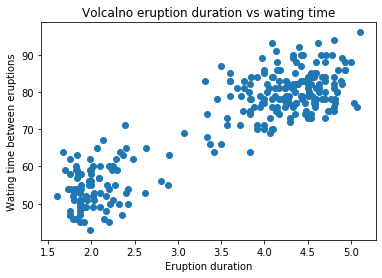

In [21]:
volcano_file = open("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/gmm-em-algorithm/Old-Faithful-Geyser Dataset.csv")
volcano_df = pd.read_csv(volcano_file)

plt.scatter(volcano_df['eruptions'], volcano_df['waiting'])
plt.title('Volcalno eruption duration vs wating time')
plt.xlabel('Eruption duration')
plt.ylabel('Wating time between eruptions')
plt.show()

## 3.c Bimodal GMM with random initial parameters

GMM means:
[[ 3.48014259 70.61733342]
 [ 3.49489235 71.15733491]]


GM covariances matrix:
[[[  1.30711049  14.06939085]
  [ 14.06939085 185.86259677]]

 [[  1.28930206  13.78954868]
  [ 13.78954868 182.40399235]]]


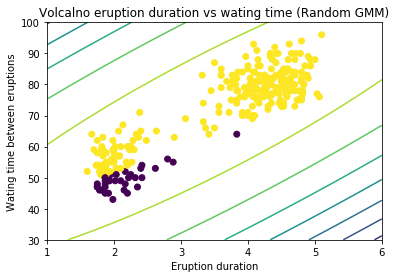

In [22]:
gmm = GaussianMixture(n_components=2, init_params='random')
gmm.fit(volcano_df)
gmm_clusters = gmm.predict(volcano_df)

print('GMM means:')
print(gmm.means_)
print('\n')
print('GM covariances matrix:')
print(gmm.covariances_)

X, Y = np.meshgrid(np.linspace(1, 6), np.linspace(30,100))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape(X.shape)
 
plt.contour(X, Y, Z)
plt.scatter(volcano_df['eruptions'], volcano_df['waiting'], c=gmm_clusters)
plt.title('Volcalno eruption duration vs wating time (Random GMM)')
plt.xlabel('Eruption duration')
plt.ylabel('Wating time between eruptions')
plt.show()

## 3.d Bimodel GMM with K-Means pre-processing

GMM means:
[[ 4.28977944 79.96953298]
 [ 2.03652149 54.47986018]]


GM covariances matrix:
[[[ 0.16982046  0.93871793]
  [ 0.93871793 36.02497019]]

 [[ 0.06927449  0.43627723]
  [ 0.43627723 33.70493352]]]


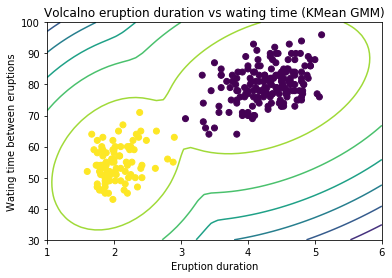

In [23]:
gmm = GaussianMixture(n_components=2, init_params='kmeans')
gmm.fit(volcano_df)
gmm_clusters = gmm.predict(volcano_df)

print('GMM means:')
print(gmm.means_)
print('\n')
print('GM covariances matrix:')
print(gmm.covariances_)


X, Y = np.meshgrid(np.linspace(1, 6), np.linspace(30,100))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape(X.shape)
 
plt.contour(X, Y, Z)
plt.scatter(volcano_df['eruptions'], volcano_df['waiting'], c=gmm_clusters)
plt.plot

plt.title('Volcalno eruption duration vs wating time (KMean GMM)')
plt.xlabel('Eruption duration')
plt.ylabel('Wating time between eruptions')
plt.show()


# 4. Multidimensional scaling for genetic population

In [24]:
from sklearn.manifold import MDS 

gene_data = np.load("/Users/zweedaothaiduy/Dropbox/Document/Study/Cornell Modules/Applied Machine Learning ECE5414/homework-3/mds-gene/mds-population.npz")

distance_df = pd.DataFrame(gene_data['D']) # Distance matrix
populations = pd.DataFrame(gene_data['population_list']) # List of populations


## 4.a MDS 

/Users/zweedaothaiduy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


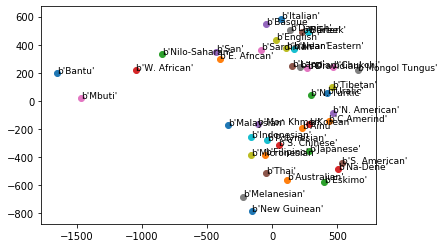

In [25]:
mds = MDS(n_components=2)
distance_mds = mds.fit_transform(distance_df)

for i,population in enumerate(populations[0]):
    plt.scatter(distance_mds[i,0],distance_mds[i,1])
    plt.text(distance_mds[i,0]+0.5, distance_mds[i,1]+0.5, population, fontsize=9)
plt.show()


## 4.b K-means on 2D embedding

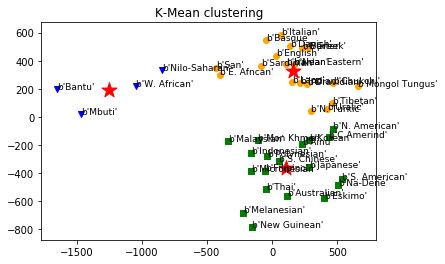

In [27]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=3)
kmean_clusters = k_means.fit_predict(distance_mds)

#plot clusters
for i,population in enumerate(populations[0]):
    if kmean_clusters[i] == 0:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='green',marker='s',label='cluster 0')
    elif kmean_clusters[i] == 1:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='orange',marker='o',label='cluster 1')
    elif kmean_clusters[i] == 2:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='blue',marker='v',label='cluster 2')
#    elif clusters[i] == 3:
#        plt.scatter(distance_mds[i,0],distance_mds[i,1],
#                c='lightblue',marker='v',label='cluster 3')
    plt.text(distance_mds[i,0]+0.5, distance_mds[i,1]+0.5, population, fontsize=9)

#plot centroids
plt.scatter(
    k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1],
    s=250, marker='*', c='red', label='centroids'
)

plt.title('K-Mean clustering')
plt.show()

## 4.c Hierarchical clustering

/Users/zweedaothaiduy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


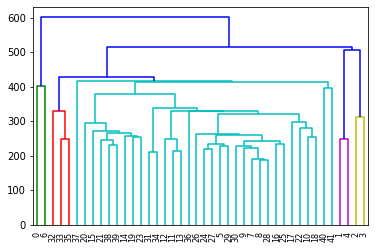

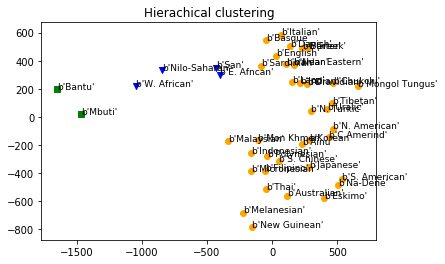

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linked = linkage(distance_df,'single')
labels = distance_df.index.values

plt.figure()
dendrogram(linked, labels=labels)
plt.show()

hierachy_clusters = fcluster(linked,t=510,criterion='distance')

#plot clusters
for i,population in enumerate(populations[0]):
    if hierachy_clusters[i] == 1:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='green',marker='s',label='cluster 1')
    elif hierachy_clusters[i] == 2:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='orange',marker='o',label='cluster 2')
    elif hierachy_clusters[i] == 3:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='blue',marker='v',label='cluster 3')
#    elif clusters[i] == 3:
#        plt.scatter(distance_mds[i,0],distance_mds[i,1],
#                c='lightblue',marker='v',label='cluster 3')
    plt.text(distance_mds[i,0]+0.5, distance_mds[i,1]+0.5, population, fontsize=9)

plt.title('Hierachical clustering')
plt.show()

## 4.d K-medoids

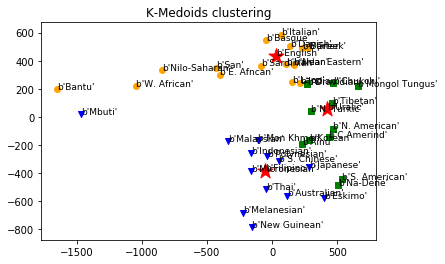

In [29]:
import subprocess
import sys
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
install('https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip')
from sklearn_extra.cluster import KMedoids

k_medoids = KMedoids(n_clusters=3)
kmedoids_clusters = k_medoids.fit_predict(distance_mds)

#plot clusters
for i,population in enumerate(populations[0]):
    if kmedoids_clusters[i] == 0:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='green',marker='s',label='cluster 0')
    elif kmedoids_clusters[i] == 1:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='orange',marker='o',label='cluster 1')
    elif kmedoids_clusters[i] == 2:
        plt.scatter(distance_mds[i,0],distance_mds[i,1],
                    c='blue',marker='v',label='cluster 2')
#    elif clusters[i] == 3:
#        plt.scatter(distance_mds[i,0],distance_mds[i,1],
#                c='lightblue',marker='v',label='cluster 3')
    plt.text(distance_mds[i,0]+0.5, distance_mds[i,1]+0.5, population, fontsize=9)

#plot centroids
plt.scatter(
    k_medoids.cluster_centers_[:, 0], k_medoids.cluster_centers_[:, 1],
    s=250, marker='*', c='red', label='centroids'
)

plt.title('K-Medoids clustering')
plt.show()